In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi)
ZERO = torch.tensor([0.]).to(device)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            u1 = self.fc2(torch.heaviside(self.fc1(x),torch.tensor([0.])) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1

def plot_2D(f): 
    
    Nx = 400
    Ny = 400 
    xs = np.linspace(0, 1, Nx)
    ys = np.linspace(0, 1, Ny)
    x, y = np.meshgrid(xs, ys, indexing='xy')
    xy_comb = np.stack((x.flatten(),y.flatten())).T
    xy_comb = torch.tensor(xy_comb)
    z = f(xy_comb).reshape(Nx,Ny)
    z = z.detach().numpy()
    plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x , y , z )

    plt.show()

def plot_subdomains(my_model):
    x_coord =torch.linspace(0,1,200)
    wi = my_model.fc1.weight.data
    bi = my_model.fc1.bias.data 
    for i, bias in enumerate(bi):  
        if wi[i,1] !=0: 
            plt.plot(x_coord, - wi[i,0]/wi[i,1]*x_coord - bias/wi[i,1])
        else: 
            plt.plot(x_coord,  - bias/wi[i,0]*torch.ones(x_coord.size()))

    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.show()
    return 0   

## Initialization
def adjust_neuron_position(my_model,target=None):
    counter = 0 
    positions = torch.tensor([[0.,0.],[0.,1.],[1.,1.],[1.,0.]])
    neuron_num = my_model.fc1.bias.size(0)
    for i in range(neuron_num): 
        w = my_model.fc1.weight.data[i:i+1,:]
        b = my_model.fc1.bias.data[i]
        values = torch.matmul(positions,w.T) # + b
        left_end = - torch.max(values)
        right_end = - torch.min(values) 
        off_set = (right_end - left_end)/1000 
        if b <= left_end + off_set: # nearly vanishing
            b = torch.rand(1)*(right_end - left_end - off_set*2) + left_end + off_set 
            my_model.fc1.bias.data[i] = b 
        if b >= right_end - off_set: # nearly nonvanishing everywhere
            if counter < 3:
                counter += 1
            else: # 3 or more 
                b = torch.rand(1)*(right_end - left_end - off_set*2) + left_end + off_set
                my_model.fc1.bias.data[i] = b 
    return my_model

In [2]:
def show_convergence_order2(err_l2,err_h10,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.6f} \t\t * \t\t {:.6f} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex2(err_l2,err_h10,exponent,k=1,d=1): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    l2_order = -1/2-(2*k + 1)/(2*d)
    h1_order =  -1/2-(2*(k-1)+ 1)/(2*d)
    print("neuron num  & \t $\|u-u_n \|_{{L^2}}$ & \t order $O(n^{{{:.2f}}})$  & \t $ | u -u_n |_{{H^1}}$ & \t order $O(n^{{{:.2f}}})$  \\\ \hline \hline ".format(l2_order,h1_order))
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t & {:.6f} &\t\t * & \t\t {:.6f} & \t\t *  \\\ \hline  \n".format(neuron_nums[i],item, err_list2[i] ) )   
        else: 
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} &  \t\t {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )


In [3]:
def PiecewiseGQ2D_weights_points(Nx, order): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """

#     print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1).T
    weights =  (w*w[:,None]).ravel()

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**2,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**2 /4 

    integration_points = torch.tile(gauss_pts,(Nx**2,1))
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(2,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**2)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,2)
    # print(ordered_pairs)
    translation = ordered_pairs*h 
    # print(translation)

    integration_points = integration_points + translation 
#     print(integration_points.size())
    # func_values = integrand2_torch(integration_points)
    return long_weights, integration_points


def minimize_linear_layer_H1_explicit_assemble_efficient(model,target,weights, integration_points,activation = 'relu',solver="direct" ):

    # weights, integration_points = PiecewiseGQ2D_weights_points(Nx, order) 
    # integration_points.requires_grad_(True) 
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    neuron_num = b.size(0) 

    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, torch.tensor([0.])) * w.t()[0:1,:] 
            basis_value_dy_col = torch.heaviside(integration_points @ w.t()+ b,torch.tensor([0.])) * w.t()[1:2,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
            basis_value_dy_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[1:2,:] 
    # elif activation == 'tanh': 
    #     basis_value_col = torch.tanh(integration_points @ w.t()+ b) 
    #     basis_value_dx_col = tanh_activation_dx(integration_points @ w.t()+ b) * w.t()[0:1,:]
    #     basis_value_dy_col = tanh_activation_dx(integration_points @ w.t()+ b) * w.t()[1:2,:]
    # elif activation == 'gaussian':
    #     basis_value_col = Gaussian_activation(integration_points @ w.t()+ b)
    #     basis_value_dx_col = Gaussian_activation_dx(integration_points @ w.t()+ b) * w.t()[0:1,:]
    #     basis_value_dy_col = Gaussian_activation_dx(integration_points @ w.t()+ b) * w.t()[1:2,:]
    # elif activation == 'cosine':
    #     basis_value_col = cosine_activation(integration_points @ w.t()+ b) 
    #     basis_value_dx_col = cosine_activation_dx(integration_points @ w.t()+ b) * w.t()[0:1,:]
    #     basis_value_dy_col = cosine_activation_dx(integration_points @ w.t()+ b) * w.t()[1:2,:] 

    weighted_basis_value_col = basis_value_col * weights 
    jac1 = weighted_basis_value_col.t() @ basis_value_col  # mass matrix 
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the mass matrix time taken: ", time.time()-start_time) 

    start_time = time.time() 
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    weighted_basis_value_dy_col = basis_value_dy_col * weights
    jac2 = weighted_basis_value_dx_col.t() @ basis_value_dx_col + weighted_basis_value_dy_col.t() @ basis_value_dy_col 
    print("assembling the stiffness matrix time taken: ", time.time()-start_time)   
    jac = jac1 + jac2    
    
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 


def OGANeumannReLU2D(my_model,target,u_exact, u_exact_grad, N_list,num_epochs,plot_freq, Nx, order, k =1, rand_deter = 'deter', linear_solver = "direct"): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    #Todo Done
    gw_expand, integration_points = PiecewiseGQ2D_weights_points(Nx, order)
    gw_expand = gw_expand.to(device)
    integration_points = integration_points.to(device)

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1).to(device) 
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0

        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))

        list_b = list(bias)
        list_w = list(weights)
    
    # initial error Todo Done
    func_values_sqrd = func_values*func_values
    # print(func_values_sqrd.size())
    # print(gw_expand.size()) 
    err[0]= torch.sum(func_values_sqrd*gw_expand)**0.5
    ## h1 seminorm 
    if u_exact_grad != None:
        u_grad = u_exact_grad() 
        for grad_i in u_grad: 
            err_h10[0] += torch.sum((grad_i(integration_points))**2 * gw_expand)**0.5
#             err_h10[0] += ( gw_expand.t() @ ((grad_i(integration_points))**2) )**0.5
    
    start_time = time.time()
    solver = linear_solver

    N0 = np.prod(N_list)
    if rand_deter == 'deter':
        relu_dict_parameters = generate_relu_dict2D(N_list).to(device)
    print("using linear solver: ",solver)
    for i in range(num_epochs): 
        print("epoch: ",i+1, end = '\t')
        if rand_deter == 'rand':
            relu_dict_parameters = generate_relu_dict2D_QMC(1,N0).to(device) 
        if num_neuron == 0: 
            func_values = - target(integration_points)
        else: 
            func_values = - target(integration_points) + my_model(integration_points).detach()

        weight_func_values = func_values*gw_expand  
        basis_values = (F.relu( torch.matmul(integration_points,relu_dict_parameters[:,0:2].T ) - relu_dict_parameters[:,2])**k).T # uses broadcasting
        
        if k == 1:  
            dbasis_values_dx1 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2], torch.tensor([0.])) * relu_dict_parameters.t()[0:1,:]  
            dbasis_values_dx2 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2], torch.tensor([0.])) * relu_dict_parameters.t()[1:2,:] 
            weight_dbasis_values_dx1 =  dbasis_values_dx1 * gw_expand
            weight_dbasis_values_dx2 =  dbasis_values_dx2 * gw_expand 
            if my_model!= None:
                dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
                dmy_model_dx2 = my_model.evaluate_derivative(integration_points,2).detach() 
        else:  
            dbasis_values_dx1 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2])**(k-1) * relu_dict_parameters.t()[0:1,:] 
            dbasis_values_dx2 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:2].T) - relu_dict_parameters[:,2])**(k-1) * relu_dict_parameters.t()[1:2,:] 
            weight_dbasis_values_dx1 =  dbasis_values_dx1 * gw_expand
            weight_dbasis_values_dx2 =  dbasis_values_dx2 * gw_expand 
            if my_model!= None:
                dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
                dmy_model_dx2 = my_model.evaluate_derivative(integration_points,2).detach()


        output1 = torch.matmul(basis_values,weight_func_values) #
        if my_model!= None:
            output2 = torch.matmul(weight_dbasis_values_dx1.t(), dmy_model_dx1) 
            output3 = torch.matmul(weight_dbasis_values_dx2.t(), dmy_model_dx2) 
            output = torch.abs(output1 + output2 + output3) 
        else: 
            output = torch.abs(output1) 
        # output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 
        neuron_index = torch.argmax(output.flatten())
        
        # print(neuron_index)
        list_w.append(relu_dict_parameters[neuron_index,0:2]) # 
        list_b.append(-relu_dict_parameters[neuron_index,2])
        num_neuron += 1
        my_model = model(2,num_neuron,1,k).to(device)
        w_tensor = torch.stack(list_w, 0 ) 
        b_tensor = torch.tensor(list_b)
        my_model.fc1.weight.data[:,:] = w_tensor[:,:]
        my_model.fc1.bias.data[:] = b_tensor[:]

        #Todo Done 
        sol = minimize_linear_layer_H1_explicit_assemble_efficient(my_model,target,gw_expand, integration_points,activation = 'relu',solver = solver)

        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            plot_2D(my_model.cpu())
            my_model = my_model.to(device)

        model_values = my_model(integration_points).detach()
        # func_values = target(integration_points) - model_values
        # func_values_sqrd = func_values*func_values

        # L2 error ||u - u_n||
        diff_values_sqrd = (u_exact(integration_points) - model_values)**2 
        err[i+1]= torch.sum(diff_values_sqrd*gw_expand)**0.5
        
        # H10 error || grad(u) - grad(u_n) ||
        if u_exact_grad != None:
            for ind, grad_i in enumerate(u_grad):  
                my_model_dxi = my_model.evaluate_derivative(integration_points,ind+1).detach() 
                err_h10[i+1] += torch.sum((grad_i(integration_points) - my_model_dxi)**2 * gw_expand)**0.5
#                 err_h10[0] += ( gw_expand.t() @ ((grad_i(integration_points) - my_model_dxi)**2) )**0.5
    print("time taken: ",time.time() - start_time)
    return err, err_h10.cpu(), my_model

def generate_relu_dict2D(N_list):
    N1 = N_list[0] 
    N2 = N_list[1]
    
    theta = np.linspace(0, 2*pi, N1, endpoint= False).reshape(N1,1)
    W1 = np.cos(theta)
    W2 = np.sin(theta)
    W = np.concatenate((W1,W2),1) # N1 x 2
    b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1)
    
    index1 = np.arange(N1)
    index2 = np.arange(N2)
    ordered_pairs = np.array(np.meshgrid(index1,index2,indexing='ij'))

    ordered_pairs = ordered_pairs.reshape(2,-1).T
    W = W[ordered_pairs[:,0],:]
    b = b[ordered_pairs[:,1],:]
    Wb = np.concatenate((W,b),1) # N1 x 3 
    Wb_tensor = torch.from_numpy(Wb) 
    return Wb_tensor


def generate_relu_dict2D_QMC(s,N0):

#     Sob = torch.quasirandom.SobolEngine(dimension =2, scramble= True, seed=None) 
#     samples = Sob.draw(N0).double()

#     for i in range(s-1):
#         samples = torch.cat([samples,Sob.draw(N0).double()],0)

    samples = torch.rand(s*N0,2) 
    
    T =torch.tensor([[2*pi,0],[0,2.84]])

    shift = torch.tensor([0,-1.42]) 

    samples = samples@T + shift 

    theta = samples[:,0].reshape(s*N0,1)
    W1 = torch.cos(theta)
    W2 = torch.sin(theta)
    W = torch.cat((W1,W2),1) # N1 x 2
    # b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1) 
    b = samples[:,1].reshape(s*N0,1)
    
    Wb = torch.cat((W,b),1) # N1 x 3 

    return Wb 


In the following tests, we compare using deterministic dictionaries with using random dictionary for the following target function. 

- $\cos(2 \pi x_1) \cos(\pi x_2)$ 


## $\cos(2 \pi x_1) \cos(\pi x_2)$ 

using linear solver:  direct
epoch:  1	assembling the mass matrix time taken:  0.0009200572967529297
assembling the stiffness matrix time taken:  0.0002148151397705078
solving Ax = b time taken:  0.0876615047454834
epoch:  2	assembling the mass matrix time taken:  0.0006101131439208984
assembling the stiffness matrix time taken:  0.00018525123596191406
solving Ax = b time taken:  0.0035715103149414062
epoch:  3	assembling the mass matrix time taken:  0.000438690185546875
assembling the stiffness matrix time taken:  6.866455078125e-05
solving Ax = b time taken:  0.00022268295288085938
epoch:  4	assembling the mass matrix time taken:  0.00045037269592285156
assembling the stiffness matrix time taken:  6.771087646484375e-05
solving Ax = b time taken:  0.00017762184143066406
epoch:  5	assembling the mass matrix time taken:  0.00045299530029296875
assembling the stiffness matrix time taken:  0.00022292137145996094
solving Ax = b time taken:  0.00017833709716796875
epoch:  6	assembling the m

epoch:  44	assembling the mass matrix time taken:  0.0004715919494628906
assembling the stiffness matrix time taken:  0.0001647472381591797
solving Ax = b time taken:  0.0005698204040527344
epoch:  45	assembling the mass matrix time taken:  0.00046133995056152344
assembling the stiffness matrix time taken:  8.177757263183594e-05
solving Ax = b time taken:  0.0007169246673583984
epoch:  46	assembling the mass matrix time taken:  0.0004935264587402344
assembling the stiffness matrix time taken:  0.0001747608184814453
solving Ax = b time taken:  0.0005953311920166016
epoch:  47	assembling the mass matrix time taken:  0.00045418739318847656
assembling the stiffness matrix time taken:  7.772445678710938e-05
solving Ax = b time taken:  0.0007715225219726562
epoch:  48	assembling the mass matrix time taken:  0.0005228519439697266
assembling the stiffness matrix time taken:  0.0001609325408935547
solving Ax = b time taken:  0.0006177425384521484
epoch:  49	assembling the mass matrix time taken

epoch:  87	assembling the mass matrix time taken:  0.00042700767517089844
assembling the stiffness matrix time taken:  0.00020456314086914062
solving Ax = b time taken:  0.0017325878143310547
epoch:  88	assembling the mass matrix time taken:  0.0004572868347167969
assembling the stiffness matrix time taken:  8.368492126464844e-05
solving Ax = b time taken:  0.0018312931060791016
epoch:  89	assembling the mass matrix time taken:  0.00043272972106933594
assembling the stiffness matrix time taken:  7.843971252441406e-05
solving Ax = b time taken:  0.0018947124481201172
epoch:  90	assembling the mass matrix time taken:  0.0004715919494628906
assembling the stiffness matrix time taken:  0.000156402587890625
solving Ax = b time taken:  0.0018732547760009766
epoch:  91	assembling the mass matrix time taken:  0.0004317760467529297
assembling the stiffness matrix time taken:  7.343292236328125e-05
solving Ax = b time taken:  0.001957416534423828
epoch:  92	assembling the mass matrix time taken:

epoch:  130	assembling the mass matrix time taken:  0.0004315376281738281
assembling the stiffness matrix time taken:  0.00016808509826660156
solving Ax = b time taken:  0.0032901763916015625
epoch:  131	assembling the mass matrix time taken:  0.00043511390686035156
assembling the stiffness matrix time taken:  7.724761962890625e-05
solving Ax = b time taken:  0.0034165382385253906
epoch:  132	assembling the mass matrix time taken:  0.0004420280456542969
assembling the stiffness matrix time taken:  0.0001590251922607422
solving Ax = b time taken:  0.0032956600189208984
epoch:  133	assembling the mass matrix time taken:  0.0004315376281738281
assembling the stiffness matrix time taken:  8.511543273925781e-05
solving Ax = b time taken:  0.0034918785095214844
epoch:  134	assembling the mass matrix time taken:  0.00043892860412597656
assembling the stiffness matrix time taken:  0.0001857280731201172
solving Ax = b time taken:  0.0033919811248779297
epoch:  135	assembling the mass matrix tim

epoch:  174	assembling the mass matrix time taken:  0.0004267692565917969
assembling the stiffness matrix time taken:  0.0001919269561767578
solving Ax = b time taken:  0.004168510437011719
epoch:  175	assembling the mass matrix time taken:  0.0004296302795410156
assembling the stiffness matrix time taken:  8.606910705566406e-05
solving Ax = b time taken:  0.004324197769165039
epoch:  176	assembling the mass matrix time taken:  0.00042557716369628906
assembling the stiffness matrix time taken:  7.891654968261719e-05
solving Ax = b time taken:  0.004309892654418945
epoch:  177	assembling the mass matrix time taken:  0.00043773651123046875
assembling the stiffness matrix time taken:  0.00016736984252929688
solving Ax = b time taken:  0.004276752471923828
epoch:  178	assembling the mass matrix time taken:  0.00042819976806640625
assembling the stiffness matrix time taken:  7.915496826171875e-05
solving Ax = b time taken:  0.004406452178955078
epoch:  179	assembling the mass matrix time ta

epoch:  219	assembling the mass matrix time taken:  0.0004336833953857422
assembling the stiffness matrix time taken:  0.00016760826110839844
solving Ax = b time taken:  0.0059642791748046875
epoch:  220	assembling the mass matrix time taken:  0.00046324729919433594
assembling the stiffness matrix time taken:  7.843971252441406e-05
solving Ax = b time taken:  0.006083488464355469
epoch:  221	assembling the mass matrix time taken:  0.0004360675811767578
assembling the stiffness matrix time taken:  8.535385131835938e-05
solving Ax = b time taken:  0.006087541580200195
epoch:  222	assembling the mass matrix time taken:  0.0004658699035644531
assembling the stiffness matrix time taken:  0.0001666545867919922
solving Ax = b time taken:  0.0062673091888427734
epoch:  223	assembling the mass matrix time taken:  0.00044035911560058594
assembling the stiffness matrix time taken:  7.82012939453125e-05
solving Ax = b time taken:  0.006125211715698242
epoch:  224	assembling the mass matrix time ta

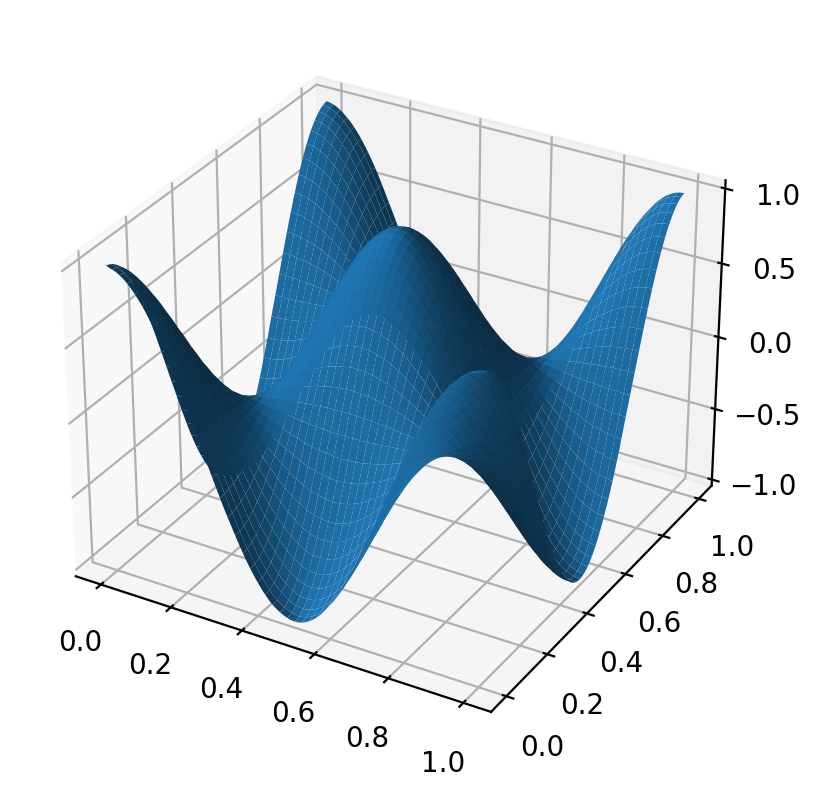

time taken:  27.870600938796997
neuron num 		 error 		 order
4 		 0.534747 		 * 		 6.214953 		 * 

8 		 0.369543 		 0.533115 		 4.642788 		 0.420752 

16 		 0.046181 		 3.000357 		 1.274205 		 1.865394 

32 		 0.011809 		 1.967394 		 0.478056 		 1.414345 

64 		 0.002722 		 2.117187 		 0.169065 		 1.499601 

128 		 0.000681 		 1.998903 		 0.066065 		 1.355630 

256 		 0.001111 		 -0.706707 		 0.172032 		 -1.380728 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-1.75})$  & 	 $ | u -u_n |_{H^1}$ & 	 order $O(n^{-1.25})$  \\ \hline \hline 
4 		 & 0.534747 &		 * & 		 6.214953 & 		 *  \\ \hline  

8 		 &  3.695e-01 &  		 0.53 &  		 4.643e+00 &  		 0.42 \\ \hline  

16 		 &  4.618e-02 &  		 3.00 &  		 1.274e+00 &  		 1.87 \\ \hline  

32 		 &  1.181e-02 &  		 1.97 &  		 4.781e-01 &  		 1.41 \\ \hline  

64 		 &  2.722e-03 &  		 2.12 &  		 1.691e-01 &  		 1.50 \\ \hline  

128 		 &  6.810e-04 &  		 2.00 &  		 6.606e-02 &  		 1.36 \\ \hline  

256 		 &  1.111e-03 &  		 -0.71 &  		 1.720e

In [4]:
m1 = 2 
m2 = 2 
def u_exact(x):
    return torch.cos(m1 * pi*x[:,0:1])*torch.cos(m2 * pi*x[:,1:2]) 

def u_exact_grad(): 
    def grad_1(x):
        return - m1*pi* torch.sin(m1*pi*x[:,0:1])*torch.cos( m2*pi*x[:,1:2]) 
    def grad_2(x):
        return - m2*pi* torch.cos(m1*pi*x[:,0:1])*torch.sin( m2*pi*x[:,1:2]) 

    u_grad=[grad_1, grad_2] 

    return u_grad
def target(x):
    z = ( (m1*pi)**2 + (m2*pi)**2 + 1)*torch.cos(m1 * pi*x[:,0:1])*torch.cos(m2  * pi*x[:,1:2] )
    return z 

dim = 2 
function_name = "cospix2d" 
filename_write = "data/2DOGA-{}-order.txt".format(function_name)
Nx = 100   
order = 3   
f_write = open(filename_write, "a")
f_write.write("Integration points: Nx {}, order {} \n".format(Nx,order))
f_write.close() 

save = True 
write2file = True
rand_deter = 'rand'
for N_list in [[2**6,2**6]]: # ,[2**6,2**6],[2**7,2**7] 
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 8  
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    N = np.prod(N_list)
    relu_k = 2 
    err_QMC2, err_h10, my_model = OGANeumannReLU2D(my_model,target,u_exact,u_exact_grad, N_list,num_epochs,plot_freq, Nx, order, k = relu_k, rand_deter= rand_deter, linear_solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_NeumannOGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_NeumannOGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    show_convergence_order2(err_QMC2,err_h10,exponent,N,filename_write,write2file = write2file)
    show_convergence_order_latex2(err_QMC2,err_h10,exponent,k=relu_k,d = dim)


In [5]:
## 